In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)

In [10]:
m_col = inspector.get_columns('measurement')
for c in m_col:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
s_col = inspector.get_columns('station')
for c in s_col:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recent_date)

2017-08-23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
months = 12
date_format = '%Y-%m-%d'
dtObj = dt.datetime.strptime(recent_date,date_format)
oldest_date = dtObj - pd.DateOffset(months=months)
oldest_date = oldest_date.strftime(date_format)
print(oldest_date)

2016-08-23


In [15]:
# Perform a query to retrieve the date and precipitation scores
year_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date<=recent_date)\
            .filter(Measurement.date>=oldest_date)
print(year_data.statement)

SELECT measurement.date, measurement.prcp 
FROM measurement 
WHERE measurement.date <= :date_1 AND measurement.date >= :date_2


In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
year_df = pd.DataFrame(year_data)
year_df = year_df.set_index('date')
year_df = year_df.rename(columns={'prcp':'precipitation'})
year_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


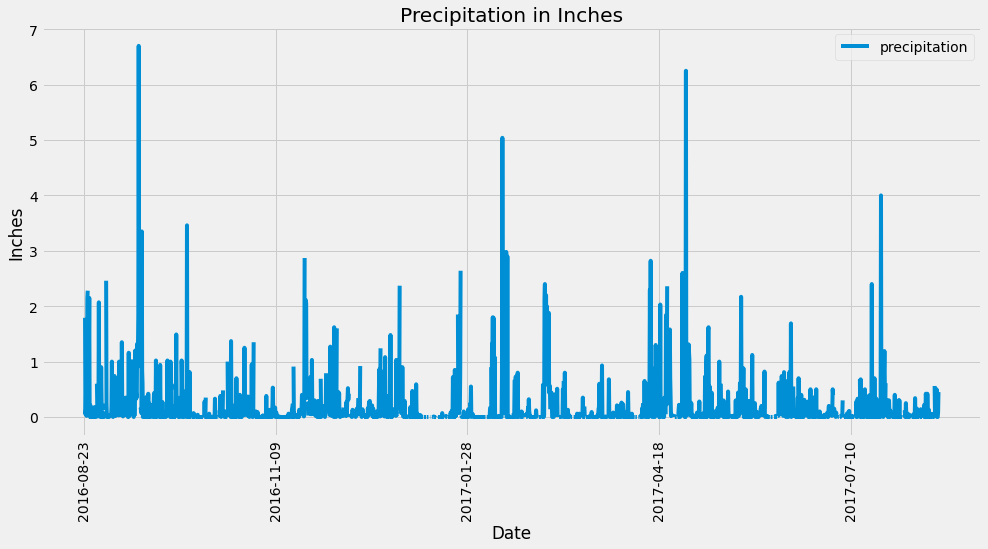

In [17]:
# Sort the dataframe by date
year_df = year_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
year_df.plot(xlabel="Date",ylabel="Inches",title="Precipitation in Inches",rot='vertical',figsize=(15,7))
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count()
print(f"There are {total_stations} stations in the dataset.")

There are 9 stations in the dataset.


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count().label("count"))\
            .group_by(Measurement.station)\
            .order_by(desc("count"),Measurement.station.desc()).all()
pd.DataFrame(station_count)

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
active_station = station_count[0][0]
print(f"The station with the most observations is {active_station}")

The station with the most observations is USC00519281


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stats = session.query(Measurement.station, \
              func.min(Measurement.tobs).label("Min Temp"),\
              func.max(Measurement.tobs).label("Max Temp"), \
              func.avg(Measurement.tobs).label("Average Temp"))\
              .filter(Measurement.station == active_station)\
              .group_by(Measurement.station).all()

pd.DataFrame(stats).head()

,station,Min Temp,Max Temp,Average Temp
0,USC00519281,54.0,85.0,71.663781


In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(Measurement.tobs).filter(Measurement.station == active_station)\
            .filter(Measurement.date<=recent_date)\
            .filter(Measurement.date>=oldest_date)
temp_df = pd.DataFrame(year_temp)
temp_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


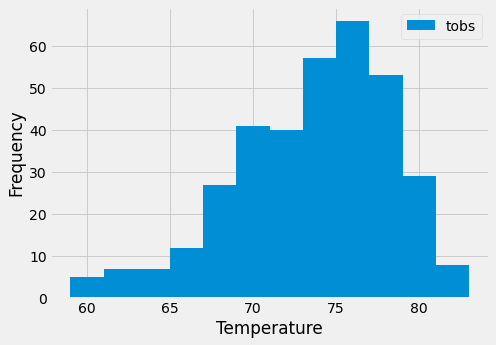

In [24]:
temp_df.plot(kind='hist',bins=12,xlabel="Temperature",figsize =(7,5)).set_xlabel("Temperature")
plt.show()

# Close session

In [25]:
# Close Session
session.close()